# 4 - Telco Customer Churn: Neural Network
## Predictive Neural Network
### Alden Chico

---

## Premise

We observed that random forest classification on the complete feature dataset was able to achieve 60% F1 on 80% total accuracy. We will keep this best performing model in mind when using deep learning to train and predict a neural network on the Telco data.

The best point to start discussion on neural networks is discussing how biological neurons work. Biological neurons consist of dendrites, the neuron, and the axon. Dendrites send electrical signals to the neuron based on information that the nervous system gathers from the rest of the body. The neuron then activates the signals gathered from the dendrites and sends an output to the axon on how the brain wants to respond to the input. The brain gathers information from the rest of the body about what's going on inside and outside the body and adjusts the dendrites neural input based on new information being gathered.

A neural network in computer programming aims to simulate the functions of our biological neurons. How a neural network works is that it feeds input to the network in the form of a vector that represents a single observation. The input vector acts as the dendrites that gather signals from the outside world for the neural network to process. The vector is then multiplied by weighted values that represent the strength of the signal and added together through the neuron. The neuron of a neural network activates the summed signal via an activation function that limits the value of the output in order to ensure a stable system. After interpreting a set number of observations, the neural network corrects the weighted values so that subsequent predictions are closer to their desired value. This process of self-correction is known as back propagation which lets the neural network make better guesses as the number of observations increases.

For the Telco customer churn dataset, the neural network looks at how factors like service pricing, gender, and age all interact with one another. The stronger the relationship is between given factors, the greater the signal weight. For a neural network, the output of the input layer can feed into the input of another neural layer to record more complex relationships between different combinations of features. For example, instead of looking at how just pricing and gender have an effect on whether or not a user will churn, a deeper neural model can observe how the combination of gender and pricing effect the services that the user is subscribed to. Deeper neural models allow for more complex relationships between features which ultimately leads to less bias in the model. To reduce model variance, the neural network needs many observations to generalize the model to the greater population.

For this part of the project, we are going to model the data on different neural architectures and observe how increasing the complexity of the model affects predictive performance on the holdout dataset.

---

## Import Data

As always, the first step in modeling data is importing it. The Telco dataset has been stored in CSV files that can be retrieved using the Pandas library.

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Import the Telco churn dataset with selected OHE features from CSV file
data = pd.read_csv('output/2-EDA/clean_telco.csv')
data = data.drop(['Unnamed: 0', 'customerID'], axis=1)

# Import the Telco churn dataset with selected OHE features from CSV file
data_all = pd.read_csv('output/2-EDA/all_features_telco.csv')
data_all = data_all.drop(['Unnamed: 0', 'customerID'], axis=1)

In [3]:
# Save all the predictors/target columns as numpy arrays for Keras
y = data['churn']
predictors = data.drop(['churn'], axis=1).values
n_cols = predictors.shape[1]

y_all = data_all['churn']
predictors_all = data_all.drop(['churn'], axis=1).values
n_cols_all = predictors_all.shape[1]

print(f'No. of columns in selected OHE column Dataset: {n_cols}')
print(f'No. of columns in non-selected OHE column Dataset: {n_cols_all}')

No. of columns in selected OHE column Dataset: 13
No. of columns in non-selected OHE column Dataset: 46


---

## Create Helper Functions to Create Neural Network

The following functions allow us to build and adjust the neural network using sequential dense layers. Dense neural layers are neural layers whos input is the output of every neuron in the layer before it. Every neuron observes different relationships from the layer before it so having more neurons can record more relationships. 

The baseline neural network consists of the single input layer that takes a single observation and feeds the values to a dense layer with a specified number of neurons. The output of the neural layer is then activated using the Rectified Linear Unit (ReLU) function whose value is 0 if the output is negative and the value itself if the output is positive. In practice, the ReLU function maintains great stability through deep neural networks.

The final layer of the model is a single neuron activated by a sigmoid function. The sigmoid function limits the output of the neural network between 0 and 1. Any value for the output less than 0.5 is considered a label of the negative class (the user didn't churn) and output greater than 0.5 is considered a label of the positive class (the user churned).

Lastly, compiling the neural network establishes the optimizer and loss function used for the classification task. For neural networks, there are two commonly used optimizers - stochastic gradient descent and adam. Adam optimizer adapts the learning rate of the neural network on every forward and backward pass through the network while stochastic gradient descent's learning rate is established before training the network. Learning rate determines how much the network should change the weights to have the output move closer towards the desired value.

The loss function is how the network determines how close the prediction is to the desired output. For binary classification, the loss function is called binary cross entropy. Because the sigmoid activation function limits the output of the network between 0 and 1, the binary cross entropy function looks at how far the prediction is off from the known 0 or 1 labels to determine the total loss from the neural network. The loss propagates through the entire network in the backward pass and changes the model's weights to move closer towards the desired value.

The functions below allow us to create the input layer, add however many layers desired, and compile the model using binary cross entropy loss and adam optimizer. The ```activate_output``` function transforms all values closer to the negative class into 0 and all values closer to the positive class into 1.

In [4]:
# Baseline neural network layer
from keras.layers import Dense
from keras.models import Sequential
def create_baseline_model(n_units, n_cols):
    model = Sequential()
    model.add(Dense(n_units, activation='relu', input_shape=(n_cols, )))
    return model

Using TensorFlow backend.


In [5]:
# Adds fully connected layers with specified amount of neurons
def add_model_layers(model, neuron_list):
    for neuron in neuron_list:
        model.add(Dense(neuron, activation='relu'))

In [6]:
# Adds the final model layer and compiles
def finish_model(model):
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
# Activates output to prediction since sigmoid output is between 0 and 1
def activate_output(y_pred):
    activ_y = []
    for y in y_pred:
        if y < 0.5:
            activ_y.append(0)
        else:
            activ_y.append(1)
    return activ_y

---

## Results Function

The results function here displays the classification report and confusion matrix between data predictions and their true values. Plot results will show us how the model performs against the holdout dataset that the neural network doesn't see in training.

In [8]:
# Function that plots confusion matrix / classification report after making predictions
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def plot_results(y_test, y_pred, output_dict=False):
    cr = classification_report(y_test, y_pred, output_dict=output_dict)
    # Display results if plot_results doesn't want to return classification report
    if output_dict == False:
        conf_mat = confusion_matrix(y_test, y_pred)
        cm_df = pd.DataFrame(conf_mat, index = ['Did Not Churn', 'Churn'],
                          columns = ['Did Not Churn', 'Churn'])
        _ = sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
        _ = plt.title('Churn Confusion Matrix', fontsize=20)
        _ = plt.ylabel('True', fontsize=14)
        _ = plt.xlabel('Predicted', fontsize=14)
        _ = plt.show()
        print(cr)
    # Only return classification report if desire dictionary results
    return cr

---

## Create and Plot F1-Scores for User Churn to Evaluate Model

```plot_f1_acc``` creates four separate plots that allow us to visualize how every model performs against one another. We're going to look at model performance against the selected and non-selected feature datasets and build line plots for F1-score and accuracy.

In [9]:
f1_dict_all = {}
acc_dict_all = {}

f1_dict_clean = {}
acc_dict_clean = {}

In [10]:
# Plot the change in F1-scores over the different NN models
def plot_f1_acc(f1_dict, acc_dict, f1_dict_clean, acc_dict_clean):
    
    fig, axs = plt.subplots(2, 2, figsize=(20,10))
    
    # Gather f1_dict values and keys from all dataset
    list_val = list(f1_dict.values())
    list_keys = list(f1_dict.keys())
    avg_f1_score = np.mean(list_val)
    
    # Gather acc_dict values and keys from all dataset
    list_acc = list(acc_dict.values())
    list_acc_keys = list(acc_dict.keys())
    avg_acc_score = np.mean(list_acc)
    
    # Gather f1_dict values and keys from all dataset
    list_val_clean = list(f1_dict_clean.values())
    list_keys_clean = list(f1_dict_clean.keys())
    avg_f1_score_clean = np.mean(list_val_clean)
    
    # Gather acc_dict values and keys from all dataset
    list_acc_clean = list(acc_dict_clean.values())
    list_acc_keys_clean = list(acc_dict_clean.keys())
    avg_acc_score_clean = np.mean(list_acc_clean)
    
    # Plot F1 Scores for All Dataset
    _ = axs[0][0].plot(list_val, marker='o', color='black', linestyle='solid', 
                 linewidth='2', label='Churn Prediction F1-Score')
    _ = axs[0][0].axhline(avg_f1_score, color='red', linestyle='dashed', label=f'Average F1-Score : {avg_f1_score:.2f}')
    _ = axs[0][0].set_title('F1-Score for Models on Non-Selected Variable Dataset', fontsize=14, fontweight='bold')
    _ = axs[0][0].set_xticks(range(len(list_val)))
    _ = axs[0][0].set_xticklabels(list_keys, rotation=60)
    _ = axs[0][0].set_xlabel('Model Description')
    _ = axs[0][0].set_ylabel('F1-Score')
    _ = axs[0][0].legend(loc='lower right')
    
    
    # Plot Accuracy Scores for All Dataset
    _ = axs[0][1].plot(list_acc, marker='o', color='black', linestyle='solid', 
                 linewidth='2', label='Accuracy')
    _ = axs[0][1].axhline(avg_acc_score, color='red', linestyle='dashed', label=f'Average Accuracy : {avg_acc_score:.2f}')
    _ = axs[0][1].set_title('Accuracy for Models on Non-Selected Variable Dataset', fontsize=14, fontweight='bold')
    _ = axs[0][1].set_xticks(range(len(list_acc)))
    _ = axs[0][1].set_xticklabels(list_acc_keys, rotation=60)
    _ = axs[0][1].set_xlabel('Model Description')
    _ = axs[0][1].set_ylabel('Accuracy')
    _ = axs[0][1].legend(loc='lower right')
    
    # Plot F1 Scores for Clean Dataset
    _ = axs[1][0].plot(list_val_clean, marker='o', color='black', linestyle='solid', 
                 linewidth='2', label='Churn Prediction F1-Score')
    _ = axs[1][0].axhline(avg_f1_score_clean, color='red', linestyle='dashed', 
                          label=f'Average F1-Score : {avg_f1_score_clean:.2f}')
    _ = axs[1][0].set_title('F1-Score for Models on Selected Variable Dataset', fontsize=14, fontweight='bold')
    _ = axs[1][0].set_xticks(range(len(list_val_clean)))
    _ = axs[1][0].set_xticklabels(list_keys_clean, rotation=60)
    _ = axs[1][0].set_xlabel('Model Description')
    _ = axs[1][0].set_ylabel('F1-Score')
    _ = axs[1][0].legend(loc='lower right')
    
    
    # Plot Accuracy Scores for Clean Dataset
    _ = axs[1][1].plot(list_acc_clean, marker='o', color='black', linestyle='solid', 
                 linewidth='2', label='Accuracy')
    _ = axs[1][1].axhline(avg_acc_score_clean, color='red', linestyle='dashed', 
                          label=f'Average Accuracy : {avg_acc_score_clean:.2f}')
    _ = axs[1][1].set_title('Accuracy for Models on Selected Variable Dataset', fontsize=14, fontweight='bold')
    _ = axs[1][1].set_xticks(range(len(list_acc_clean)))
    _ = axs[1][1].set_xticklabels(list_acc_keys_clean, rotation=60)
    _ = axs[1][1].set_xlabel('Model Description')
    _ = axs[1][1].set_ylabel('Accuracy')
    _ = axs[1][1].legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()

---

## Train-Test Split on Datasets

We will use 80% of the data to train the model and 20% of the data to predict. The ```StratifiedShuffleSplit``` function splits the datasets using the distribution of users that churned and didn't churn in the sample dataset. Using a stratified shuffle split ensures random selection of the dataset to generate training and testing data while ensuring that the ratio between users that churned and didn't churn is consistent with the population.

In [11]:
# Stratify training and testing data according to distribution of total sample
from sklearn.model_selection import StratifiedShuffleSplit

sss_clean = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss_clean.split(predictors, y):
    X_train, X_test = np.array(predictors[train_index]), np.array(predictors[test_index])
    y_train, y_test = np.array(y[train_index]), np.array(y[test_index])

sss_all = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss_clean.split(predictors_all, y_all):
    X_train_all, X_test_all = np.array(predictors_all[train_index]), np.array(predictors_all[test_index])
    y_train_all, y_test_all = np.array(y_all[train_index]), np.array(y_all[test_index])
    

print(f'Selected Feature Dataset Shape\nX_train:{X_train.shape}\nX_test: {X_test.shape}\ny_train: {y_train.shape}\ny_test: {y_test.shape}')
print(f'\nNon-Selected Feature Dataset Shape\nX_train:{X_train_all.shape}\nX_test: {X_test_all.shape}\ny_train: {y_train_all.shape}\ny_test: {y_test_all.shape}')

Selected Feature Dataset Shape
X_train:(5634, 13)
X_test: (1409, 13)
y_train: (5634,)
y_test: (1409,)

Non-Selected Feature Dataset Shape
X_train:(5634, 46)
X_test: (1409, 46)
y_train: (5634,)
y_test: (1409,)


---

## Evaluating the Baseline Model

A good starting point for using a neural network to model the data is looking at how the input layer activates the output by itself. The baseline model uses a single input layer with the same number of neurons as the number of features used to predict the outcome. The input layer is then activated to the output layer and used to predict whether or not the user churned or didn't churn. The baseline neural network only looks at simple interactions between the Telco features like user gender, age, and services subscribed. 

Just as we stratified the train-test split to holdout 20% of the data for evaluating the model, ```StratifiedKFold``` splits the training dataset into 5-Folds with close to the same distribution as the population.

The process of training and evaluating the model is as follows:
1. Define the model architecture.

2. Fit the model using training folds from the StratifiedKFold.

3. Evaluate the model using the test fold and print model accuracy.

4. After evaluating on all 5 folds, print the average and standard deviation of model accuracy.

The final model evaluation metrics are found by:
1. Defining the model architecture.

2. Fitting the model on all training data.

3. Predicting the labels of unseen data using the trained model.

4. Printing the classification report, confusion matrix, and F1/accuracy plots.

In [12]:
# Performs 5-Fold CV on the clean dataset using the baseline model
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores=[]
for train, test in kfold.split(X_train, y_train):
    # Model Architecture
    model = create_baseline_model(n_units=n_cols, n_cols=n_cols)
    _ = finish_model(model)
    
    model.fit(X_train[train], y_train[train], epochs=10, batch_size=10, verbose=False)
    scores = model.evaluate(X_train[test], y_train[test], verbose=False)
    print(f"Accuracy on Clean Dataset: {scores[1]*100:.2f}%")
    cv_scores.append(scores[1] * 100)
print(f"{np.mean(cv_scores):.2f}% (+/- {np.std(cv_scores):.2f}%)")






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








Accuracy on Clean Dataset: 76.40%
Accuracy on Clean Dataset: 79.59%
Accuracy on Clean Dataset: 78.35%
Accuracy on Clean Dataset: 79.24%
Accuracy on Clean Dataset: 77.35%
78.19% (+/- 1.18%)


In [13]:
# Performs 5-Fold CV on the non-selected feature dataset using the baseline model
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores=[]
for train, test in kfold.split(X_train_all, y_train_all):
    # Model Architecture
    model = create_baseline_model(n_units=n_cols_all, n_cols=n_cols_all)
    _ = finish_model(model)
    
    model.fit(X_train_all[train], y_train_all[train], epochs=10, batch_size=10, verbose=False)
    scores = model.evaluate(X_train_all[test], y_train_all[test], verbose=False)
    print(f"Accuracy on Non-Selected Feature Dataset {scores[1]*100:.2f}%")
    cv_scores.append(scores[1] * 100)
print(f"{np.mean(cv_scores):.2f}% (+/- {np.std(cv_scores):.2f}%)")

Accuracy on Non-Selected Feature Dataset 77.64%
Accuracy on Non-Selected Feature Dataset 79.77%
Accuracy on Non-Selected Feature Dataset 77.55%
Accuracy on Non-Selected Feature Dataset 43.48%
Accuracy on Non-Selected Feature Dataset 78.15%
71.32% (+/- 13.94%)


Confusion Matrix for Selected Feature Dataset


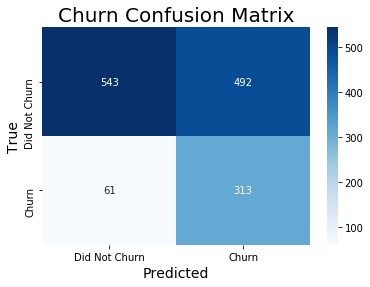

              precision    recall  f1-score   support

           0       0.90      0.52      0.66      1035
           1       0.39      0.84      0.53       374

    accuracy                           0.61      1409
   macro avg       0.64      0.68      0.60      1409
weighted avg       0.76      0.61      0.63      1409

Confusion Matrix for Non-Selected Feature Dataset


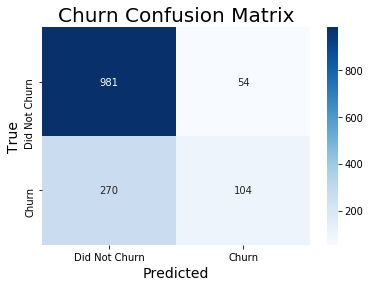

              precision    recall  f1-score   support

           0       0.78      0.95      0.86      1035
           1       0.66      0.28      0.39       374

    accuracy                           0.77      1409
   macro avg       0.72      0.61      0.62      1409
weighted avg       0.75      0.77      0.73      1409



In [14]:
# Train on all training data and predict on hold-out set

# Fit baseline model to selected feature training data
model = create_baseline_model(n_units=n_cols, n_cols=n_cols)
_ = finish_model(model)
model.fit(X_train, y_train, epochs=10, batch_size=10, verbose=False)

# Fit baseline model to non-selected feature training data
model_all = create_baseline_model(n_units=n_cols_all, n_cols=n_cols_all)
_ = finish_model(model_all)
model_all.fit(X_train_all, y_train_all, epochs=10, batch_size=10, verbose=False)

# Make predictions on testing data and print classification report
y_pred_base = activate_output(model.predict(X_test))
print('Confusion Matrix for Selected Feature Dataset')
_ = plot_results(y_test, y_pred_base)
cr_base_clean = plot_results(y_test, y_pred_base, output_dict=True)

y_pred_base_all = activate_output(model_all.predict(X_test_all))
print('Confusion Matrix for Non-Selected Feature Dataset')
_ = plot_results(y_test_all, y_pred_base_all)
cr_base_all = plot_results(y_test_all, y_pred_base_all, output_dict=True)

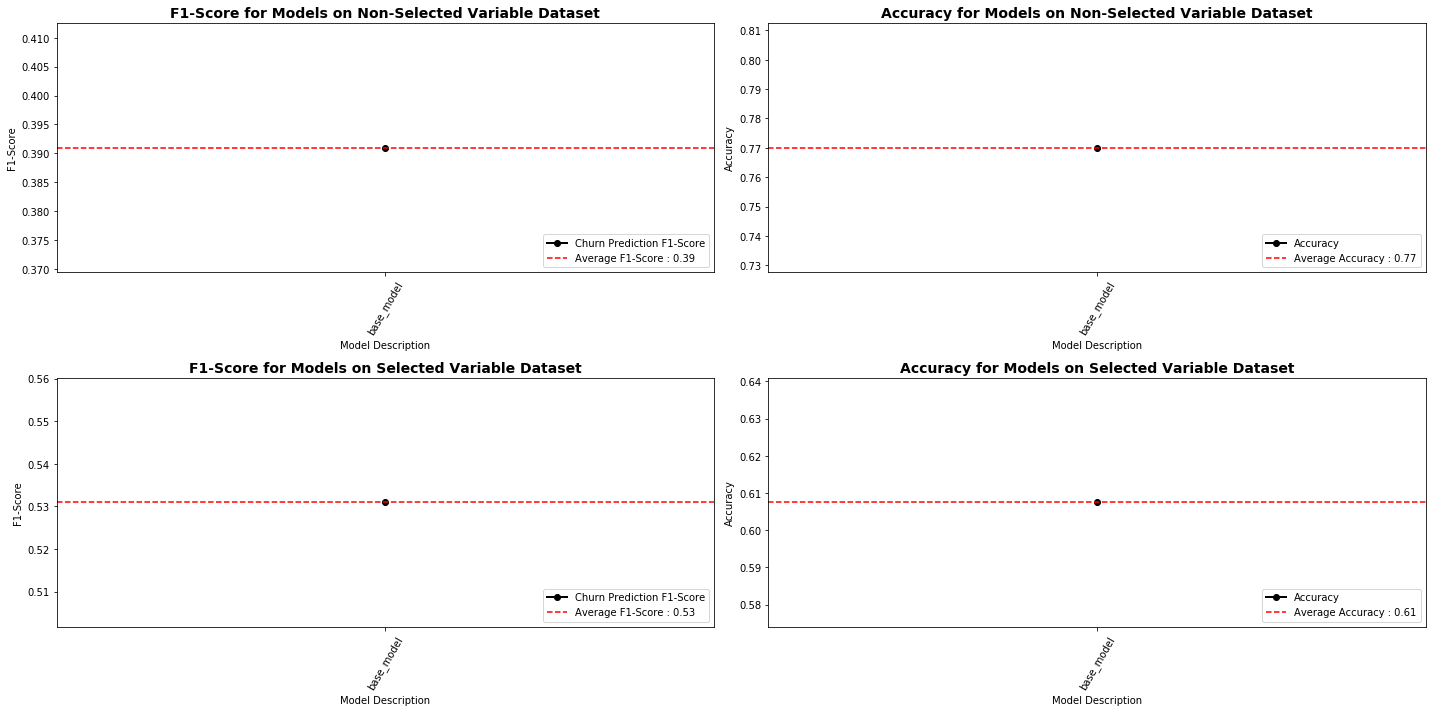

In [15]:
# Plot baseline model results
f1_dict_all['base_model'] = cr_base_all['1']['f1-score']
acc_dict_all['base_model'] = cr_base_all['accuracy']
f1_dict_clean['base_model'] = cr_base_clean['1']['f1-score']
acc_dict_clean['base_model'] = cr_base_clean['accuracy']
_ = plot_f1_acc(f1_dict_all, acc_dict_all, f1_dict_clean, acc_dict_clean)

The non-selected feature Telco dataset performed around 8% higher in F1-score and 1% worse in accuracy against the selected feature dataset. The non-selected feature dataset performs better with a neural network because the neural network can observe more feature interactions with a greater number of features. It makes sense that the Telco dataset performed better on the non-selected feature dataset since the nerual network was able to record the complex feature interactions better than the 13 selected features.

---

## Using More Hidden Layers

The next logical step in evaluating a neural network model is adding more hidden layers. More hidden layers will be able to explain more nuanced relationships from the features provided to the neural network. Adding three hidden layers will explain more complex interactions between the data from layer to layer.

In [16]:
# Performs 5-Fold CV on the selected feature dataset using a 3 hidden layer model
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores= []

# Add 3 hidden layers with n_cols number of neurons
neurons = [n_cols, n_cols, n_cols]
for train, test in kfold.split(X_train, y_train):
    # Model architecture
    model = create_baseline_model(n_units=n_cols, n_cols=n_cols)
    _ = add_model_layers(model, neurons)
    _ = finish_model(model)
    
    # Model Evaluation
    model.fit(X_train[train], y_train[train], epochs=10, batch_size=10, verbose=False)
    scores = model.evaluate(X_train[test], y_train[test], verbose=False)
    print(f"Accuracy on Selected Feature Dataset: {scores[1]*100:.2f}%")
    cv_scores.append(scores[1] * 100)
    
# Average model performance
print(f"{np.mean(cv_scores):.2f}% (+/- {np.std(cv_scores):.2f}%)")

Accuracy on Selected Feature Dataset: 78.53%
Accuracy on Selected Feature Dataset: 80.04%
Accuracy on Selected Feature Dataset: 71.61%
Accuracy on Selected Feature Dataset: 79.86%
Accuracy on Selected Feature Dataset: 78.24%
77.65% (+/- 3.11%)


In [17]:
# Performs 5-Fold CV on the non-selected feature dataset using the 3 hidden layer model
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores=[]

neurons = [n_cols_all, n_cols_all, n_cols_all]
for train, test in kfold.split(X_train_all, y_train_all):
    # Model Architecture
    model = create_baseline_model(n_units=n_cols_all, n_cols=n_cols_all)
    _ = add_model_layers(model, neurons)
    _ = finish_model(model)
    
    model.fit(X_train_all[train], y_train_all[train], epochs=10, batch_size=10, verbose=False)
    scores = model.evaluate(X_train_all[test], y_train_all[test], verbose=False)
    print(f"Accuracy on Non-Selected Feature Dataset {scores[1]*100:.2f}%")
    cv_scores.append(scores[1] * 100)
print(f"{np.mean(cv_scores):.2f}% (+/- {np.std(cv_scores):.2f}%)")

Accuracy on Non-Selected Feature Dataset 77.46%
Accuracy on Non-Selected Feature Dataset 79.33%
Accuracy on Non-Selected Feature Dataset 79.77%
Accuracy on Non-Selected Feature Dataset 79.15%
Accuracy on Non-Selected Feature Dataset 77.35%
78.61% (+/- 1.00%)


Confusion Matrix for Selected Feature Dataset


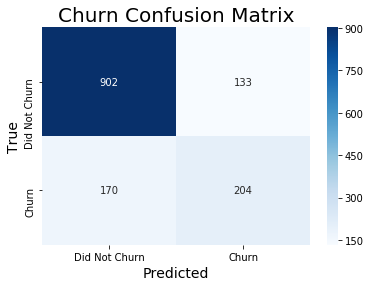

              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1035
           1       0.61      0.55      0.57       374

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.72      1409
weighted avg       0.78      0.78      0.78      1409

Confusion Matrix for Non-Selected Feature Dataset


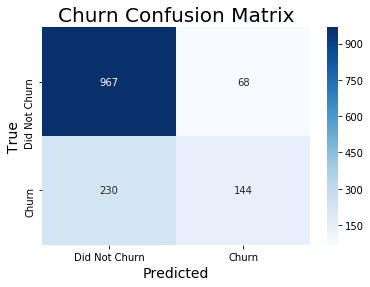

              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1035
           1       0.68      0.39      0.49       374

    accuracy                           0.79      1409
   macro avg       0.74      0.66      0.68      1409
weighted avg       0.77      0.79      0.77      1409



In [18]:
# Train on all training data and predict on hold-out set

# Fit 3 hidden layer model to all selected feature training data
neurons = [n_cols, n_cols, n_cols]
model = create_baseline_model(n_units=n_cols, n_cols=n_cols)
_ = add_model_layers(model, neurons)
_ = finish_model(model)
model.fit(X_train, y_train, epochs=10, batch_size=10, verbose=False)

# Fit 3 hidden layer model to all non-selected feature training data
neurons = [n_cols_all, n_cols_all, n_cols_all]
model_all = create_baseline_model(n_units=n_cols_all, n_cols=n_cols_all)
_ = add_model_layers(model_all, neurons)
_ = finish_model(model_all)
model_all.fit(X_train_all, y_train_all, epochs=10, batch_size=10, verbose=False)

# Make predictions on testing data and print classification report
y_pred_deep_clean = activate_output(model.predict(X_test))
print('Confusion Matrix for Selected Feature Dataset')
_ = plot_results(y_test, y_pred_deep_clean)
cr_deep_clean = plot_results(y_test, y_pred_deep_clean, output_dict=True)

y_pred_deep_all = activate_output(model_all.predict(X_test_all))
print('Confusion Matrix for Non-Selected Feature Dataset')
_ = plot_results(y_test_all, y_pred_deep_all)
cr_deep_all = plot_results(y_test_all, y_pred_deep_all, output_dict=True)

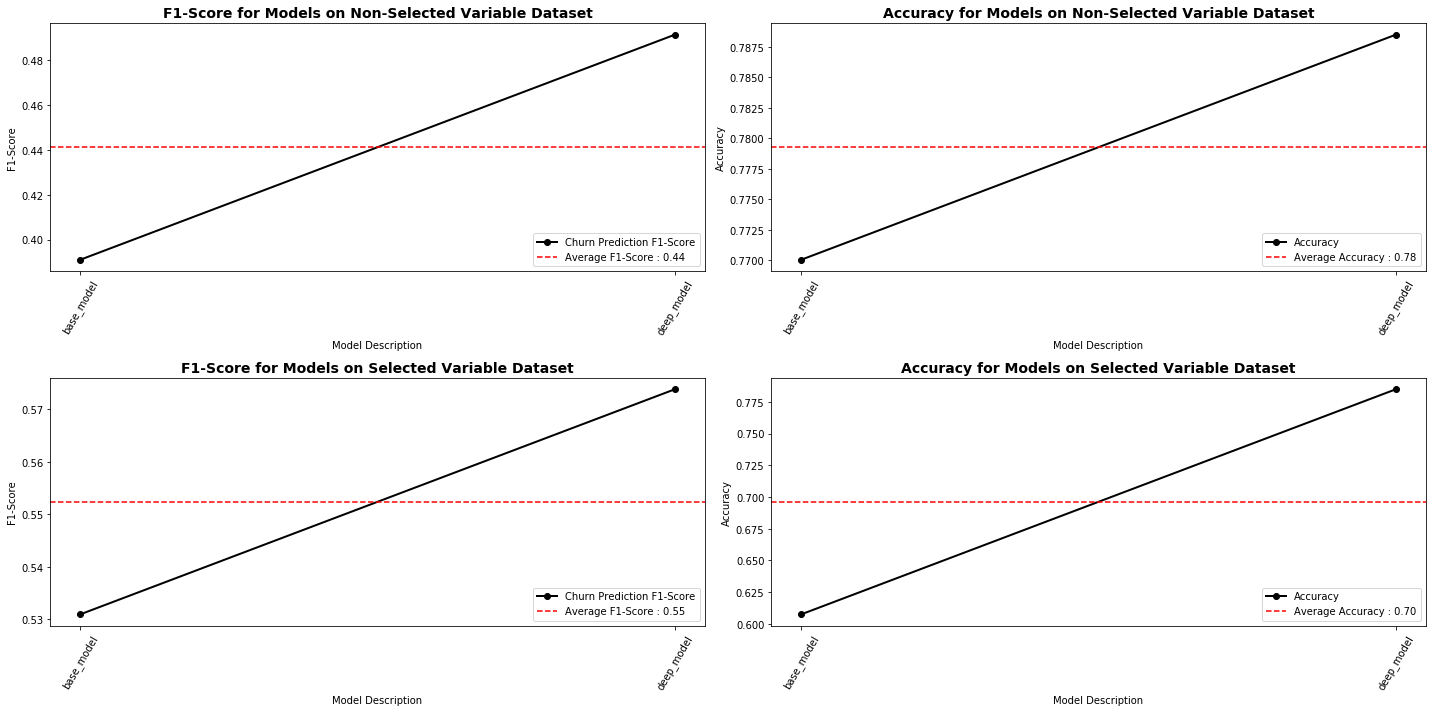

In [19]:
# Plot deep model
f1_dict_all['deep_model'] = cr_deep_all['1']['f1-score']
acc_dict_all['deep_model'] = cr_deep_all['accuracy']
f1_dict_clean['deep_model'] = cr_deep_clean['1']['f1-score']
acc_dict_clean['deep_model'] = cr_deep_clean['accuracy']
_ = plot_f1_acc(f1_dict_all, acc_dict_all, f1_dict_clean, acc_dict_clean)

The F1-score and accuracy for the non-selected Telco feature dataset performed similarly to the baseline model with only a 0.08% decrease in F1-score and 0.02% increase in accuracy. The similarity in model performance suggests that the relationships between the non-selected feature dataset aren't that complicated so increasing model complexity doesn't net substantial model improvement. The number of neurons in each hidden layer might not be enough to explain these complex relationships, so it may prove beneficial to increase the number of neurons per hidden layer to see how that affects model performance. 

Using the deeper neural model on the selected feature dataset improved the neural network model performance by 4% F1-score increase and 0.05% accuracy increase. The deeper neural network performed measurably better on the selected dataset features since more layers was able to explain nuances between the selected features that a single layer could not explain.

---

## Decreasing Batch Size

Another factor that we can adjust when fitting the Telco data to a neural network is the batch size. Batch size is the number of observations that the neural network processes before changing the model's weights. Larger batch sizes mean that the average loss has less variance than smaller batch sizes. As such, smaller batch sizes are susceptible to change from anomalous events since the average loss has greater variance. Using a batch size of 5 instead of 10 may improve model performance if the features we're using to predict customer churn are not that dependent on one another. 

In [20]:
# Performs 5-Fold CV on the selected feature dataset using a 3 hidden layer model with a 5 observation batch size
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores= []

# Add a layer with n_cols number of neurons
neurons = [n_cols, n_cols, n_cols]
for train, test in kfold.split(X_train, y_train):
    # Model architecture
    model = create_baseline_model(n_units=n_cols, n_cols=n_cols)
    _ = add_model_layers(model, neurons)
    _ = finish_model(model)
    
    # Model Evaluation
    model.fit(X_train[train], y_train[train], epochs=10, batch_size=5, verbose=False)
    scores = model.evaluate(X_train[test], y_train[test], verbose=False)
    print(f"Accuracy on Selected Feature Dataset: {scores[1]*100:.2f}%")
    cv_scores.append(scores[1] * 100)
    
# Average model performance
print(f"{np.mean(cv_scores):.2f}% (+/- {np.std(cv_scores):.2f}%)")

Accuracy on Selected Feature Dataset: 77.02%
Accuracy on Selected Feature Dataset: 77.02%
Accuracy on Selected Feature Dataset: 56.61%
Accuracy on Selected Feature Dataset: 78.35%
Accuracy on Selected Feature Dataset: 77.71%
73.34% (+/- 8.38%)


In [21]:
# Performs 5-Fold CV on the non-selected feature data using a 3 hidden layer model with a 5 observation batch size
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores=[]

neurons = [n_cols_all, n_cols_all, n_cols_all]
for train, test in kfold.split(X_train_all, y_train_all):
    # Model Architecture
    model = create_baseline_model(n_units=n_cols_all, n_cols=n_cols_all)
    _ = add_model_layers(model, neurons)
    _ = finish_model(model)
    
    model.fit(X_train_all[train], y_train_all[train], epochs=10, batch_size=5, verbose=False)
    scores = model.evaluate(X_train_all[test], y_train_all[test], verbose=False)
    print(f"Accuracy on Non-Selected Feature Dataset {scores[1]*100:.2f}%")
    cv_scores.append(scores[1] * 100)
print(f"{np.mean(cv_scores):.2f}% (+/- {np.std(cv_scores):.2f}%)")

Accuracy on Non-Selected Feature Dataset 78.97%
Accuracy on Non-Selected Feature Dataset 80.92%
Accuracy on Non-Selected Feature Dataset 79.59%
Accuracy on Non-Selected Feature Dataset 80.48%
Accuracy on Non-Selected Feature Dataset 78.42%
79.68% (+/- 0.93%)


Confusion Matrix for Selected Feature Dataset


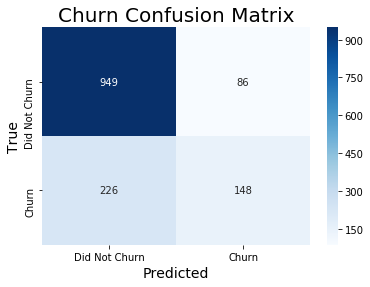

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1035
           1       0.63      0.40      0.49       374

    accuracy                           0.78      1409
   macro avg       0.72      0.66      0.67      1409
weighted avg       0.76      0.78      0.76      1409

Confusion Matrix for Non-Selected Feature Dataset


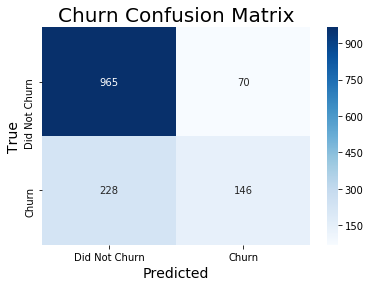

              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1035
           1       0.68      0.39      0.49       374

    accuracy                           0.79      1409
   macro avg       0.74      0.66      0.68      1409
weighted avg       0.77      0.79      0.77      1409



In [22]:
# Train on all training data and predict on hold-out set

# Fit baseline model to all selected feature training data
neurons = [n_cols, n_cols, n_cols]
model = create_baseline_model(n_units=n_cols, n_cols=n_cols)
_ = add_model_layers(model, neurons)
_ = finish_model(model)
model.fit(X_train, y_train, epochs=10, batch_size=5, verbose=False)

# Fit baseline model to all non-selected feature training data
neurons = [n_cols_all, n_cols_all, n_cols_all]
model_all = create_baseline_model(n_units=n_cols_all, n_cols=n_cols_all)
_ = add_model_layers(model_all, neurons)
_ = finish_model(model_all)
model_all.fit(X_train_all, y_train_all, epochs=10, batch_size=5, verbose=False)

# Make predictions on testing data and print classification report
y_pred_small_batch_clean = activate_output(model.predict(X_test))
print('Confusion Matrix for Selected Feature Dataset')
_ = plot_results(y_test, y_pred_small_batch_clean)
cr_small_batch_clean = plot_results(y_test, y_pred_small_batch_clean, output_dict=True)

y_pred_small_batch_all = activate_output(model_all.predict(X_test_all))
print('Confusion Matrix for Non-Selected Feature Dataset')
_ = plot_results(y_test_all, y_pred_small_batch_all)
cr_small_batch_all = plot_results(y_test_all, y_pred_small_batch_all, output_dict=True)

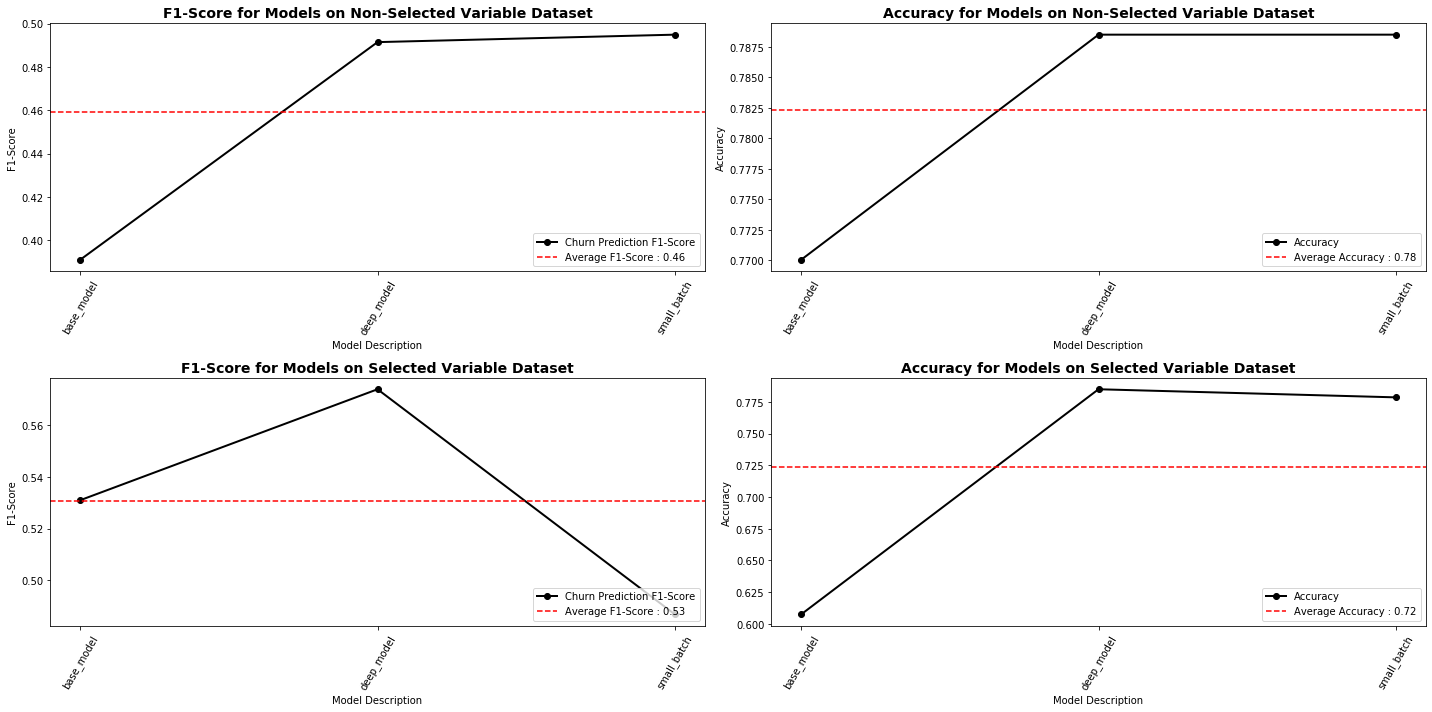

In [23]:
# Plot logistic regression results
f1_dict_all['small_batch'] = cr_small_batch_all['1']['f1-score']
acc_dict_all['small_batch'] = cr_small_batch_all['accuracy']
f1_dict_clean['small_batch'] = cr_small_batch_clean['1']['f1-score']
acc_dict_clean['small_batch'] = cr_small_batch_clean['accuracy']
_ = plot_f1_acc(f1_dict_all, acc_dict_all, f1_dict_clean, acc_dict_clean)

The F1-score improved on the selected feature dataset and got worse on the non-selected feature dataset. In fact, deep learning F1 performed best using smaller batch size on the selected features. This implies that the deep learning model improves with less feature noise if the impact of each individual user's behavior has more impact in making churn predictions. 

---

## Adjusting Hidden Layer Widths

For the next iteration of our model, we cn observe how the model performs on wider neural hidden layers. More neurons will be able to capture more relationships between features and may improve model performance. We'll start by using 50 neurons per layer before expanding the neural layer width to 100 neurons per layer.

### Hidden Layer Width - 50 Neurons / Layer

In [24]:
# Performs 5-Fold CV on the selected feature data using a 3 hidden layer model w 50 neurons/layer
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores= []

# Add 3 hidden layers with 50 neurons/layer
neurons = [50, 50, 50]
for train, test in kfold.split(X_train, y_train):
    # Model architecture
    model = create_baseline_model(n_units=n_cols, n_cols=n_cols)
    _ = add_model_layers(model, neurons)
    _ = finish_model(model)
    
    # Model Evaluation
    model.fit(X_train[train], y_train[train], epochs=10, batch_size=5, verbose=False)
    scores = model.evaluate(X_train[test], y_train[test], verbose=False)
    print(f"Accuracy on Selected Feature Dataset: {scores[1]*100:.2f}%")
    cv_scores.append(scores[1] * 100)
    
# Average model performance
print(f"{np.mean(cv_scores):.2f}% (+/- {np.std(cv_scores):.2f}%)")

Accuracy on Selected Feature Dataset: 76.75%
Accuracy on Selected Feature Dataset: 78.62%
Accuracy on Selected Feature Dataset: 78.08%
Accuracy on Selected Feature Dataset: 77.55%
Accuracy on Selected Feature Dataset: 76.91%
77.58% (+/- 0.70%)


In [25]:
# Performs 5-Fold CV on the non-selected feature data using a 3 hidden layer model w 50 neurons/layer
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores=[]

# Add 3 hidden layers with 50 neurons/layer
neurons = [50, 50, 50]
for train, test in kfold.split(X_train_all, y_train_all):
    # Model Architecture
    model = create_baseline_model(n_units=n_cols_all, n_cols=n_cols_all)
    _ = add_model_layers(model, neurons)
    _ = finish_model(model)
    
    model.fit(X_train_all[train], y_train_all[train], epochs=10, batch_size=5, verbose=False)
    scores = model.evaluate(X_train_all[test], y_train_all[test], verbose=False)
    print(f"Accuracy on Non-Selected Feature Dataset {scores[1]*100:.2f}%")
    cv_scores.append(scores[1] * 100)
print(f"{np.mean(cv_scores):.2f}% (+/- {np.std(cv_scores):.2f}%)")

Accuracy on Non-Selected Feature Dataset 78.08%
Accuracy on Non-Selected Feature Dataset 80.57%
Accuracy on Non-Selected Feature Dataset 78.97%
Accuracy on Non-Selected Feature Dataset 79.41%
Accuracy on Non-Selected Feature Dataset 77.89%
78.98% (+/- 0.97%)


Confusion Matrix for Selected Feature Dataset


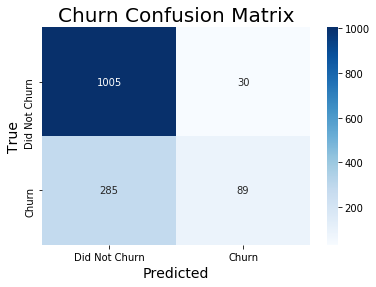

              precision    recall  f1-score   support

           0       0.78      0.97      0.86      1035
           1       0.75      0.24      0.36       374

    accuracy                           0.78      1409
   macro avg       0.76      0.60      0.61      1409
weighted avg       0.77      0.78      0.73      1409

Confusion Matrix for Non-Selected Feature Dataset


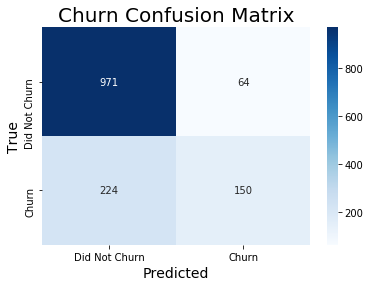

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1035
           1       0.70      0.40      0.51       374

    accuracy                           0.80      1409
   macro avg       0.76      0.67      0.69      1409
weighted avg       0.78      0.80      0.78      1409



In [26]:
# Train on all training data and predict on hold-out set

# Fit baseline model to all selected feature training data
neurons = [50, 50, 50]
model = create_baseline_model(n_units=n_cols, n_cols=n_cols)
_ = add_model_layers(model, neurons)
_ = finish_model(model)
model.fit(X_train, y_train, epochs=10, batch_size=5, verbose=False)

# Fit baseline model to all non-selected feature training data
neurons = [50, 50, 50]
model_all = create_baseline_model(n_units=n_cols_all, n_cols=n_cols_all)
_ = add_model_layers(model_all, neurons)
_ = finish_model(model_all)
model_all.fit(X_train_all, y_train_all, epochs=10, batch_size=5, verbose=False)

# Make predictions on testing data and print classification report
y_pred_50n_clean = activate_output(model.predict(X_test))
print('Confusion Matrix for Selected Feature Dataset')
_ = plot_results(y_test, y_pred_50n_clean)
cr_50n_clean = plot_results(y_test, y_pred_50n_clean, output_dict=True)

y_pred_50n_all = activate_output(model_all.predict(X_test_all))
print('Confusion Matrix for Non-Selected Feature Dataset')
_ = plot_results(y_test_all, y_pred_50n_all)
cr_50n_all = plot_results(y_test_all, y_pred_50n_all, output_dict=True)

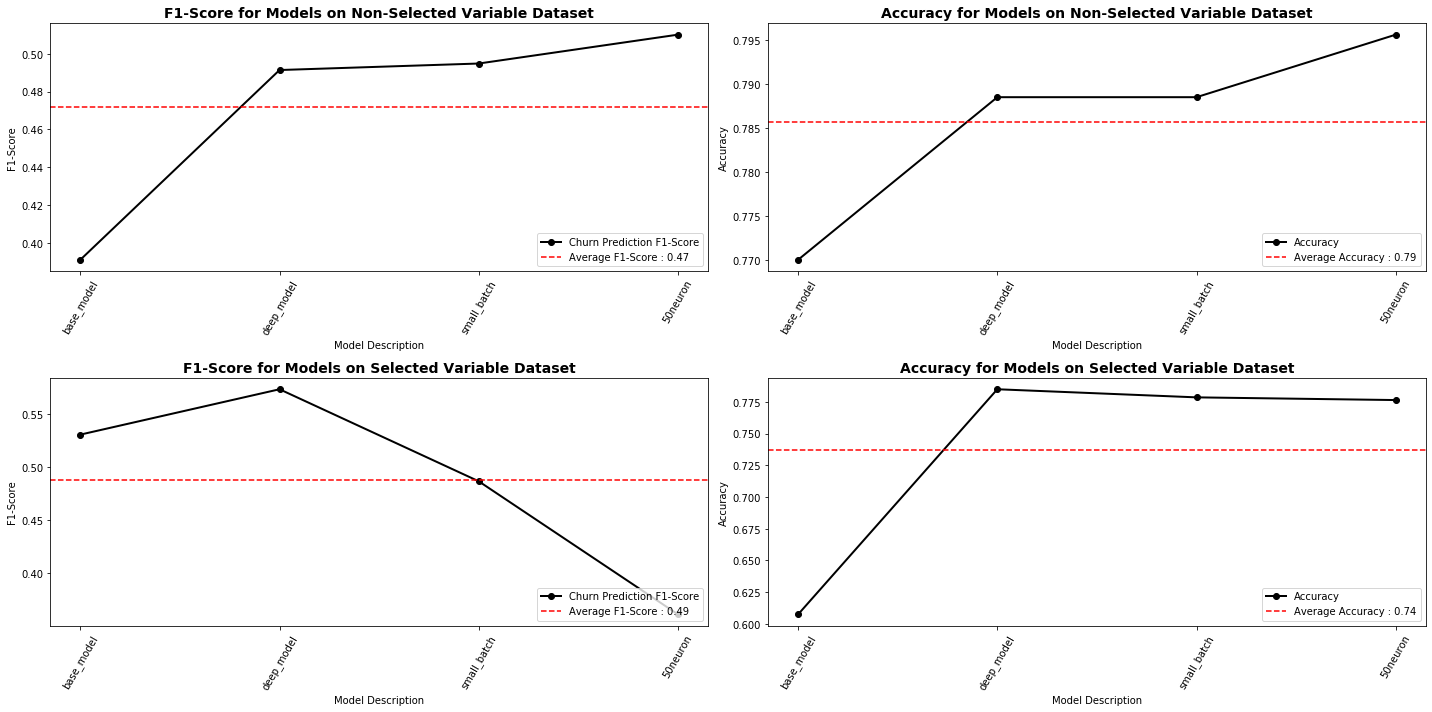

In [27]:
# Plot 50 neuron layer performance
f1_dict_all['50neuron'] = cr_50n_all['1']['f1-score']
acc_dict_all['50neuron'] = cr_50n_all['accuracy']
f1_dict_clean['50neuron'] = cr_50n_clean['1']['f1-score']
acc_dict_clean['50neuron'] = cr_50n_clean['accuracy']
_ = plot_f1_acc(f1_dict_all, acc_dict_all, f1_dict_clean, acc_dict_clean)

---

### Hidden Layer Width - 100 Neurons / Layer

In [28]:
# Performs 5-Fold CV on the selected feature data using a 3 hidden layer model w 100 neurons/layer
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores= []

# Add a layer with n_cols number of neurons
neurons = [100, 100, 100]
for train, test in kfold.split(X_train, y_train):
    # Model architecture
    model = create_baseline_model(n_units=n_cols, n_cols=n_cols)
    _ = add_model_layers(model, neurons)
    _ = finish_model(model)
    
    # Model Evaluation
    model.fit(X_train[train], y_train[train], epochs=10, batch_size=5, verbose=False)
    scores = model.evaluate(X_train[test], y_train[test], verbose=False)
    print(f"Accuracy on Selected Feature Dataset: {scores[1]*100:.2f}%")
    cv_scores.append(scores[1] * 100)
    
# Average model performance
print(f"{np.mean(cv_scores):.2f}% (+/- {np.std(cv_scores):.2f}%)")

Accuracy on Selected Feature Dataset: 75.24%
Accuracy on Selected Feature Dataset: 77.91%
Accuracy on Selected Feature Dataset: 79.15%
Accuracy on Selected Feature Dataset: 79.41%
Accuracy on Selected Feature Dataset: 75.75%
77.49% (+/- 1.71%)


In [29]:
# Performs 5-Fold CV on the non-selected feature data using a 3 hidden layer model w 100 neurons/layer
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores=[]

neurons = [100, 100, 100]
for train, test in kfold.split(X_train_all, y_train_all):
    # Model Architecture
    model = create_baseline_model(n_units=n_cols_all, n_cols=n_cols_all)
    _ = add_model_layers(model, neurons)
    _ = finish_model(model)
    
    model.fit(X_train_all[train], y_train_all[train], epochs=10, batch_size=5, verbose=False)
    scores = model.evaluate(X_train_all[test], y_train_all[test], verbose=False)
    print(f"Accuracy on Non-Selected Feature Dataset {scores[1]*100:.2f}%")
    cv_scores.append(scores[1] * 100)
print(f"{np.mean(cv_scores):.2f}% (+/- {np.std(cv_scores):.2f}%)")

Accuracy on Non-Selected Feature Dataset 76.75%
Accuracy on Non-Selected Feature Dataset 80.12%
Accuracy on Non-Selected Feature Dataset 80.04%
Accuracy on Non-Selected Feature Dataset 78.97%
Accuracy on Non-Selected Feature Dataset 79.48%
79.07% (+/- 1.23%)


Confusion Matrix for Selected Feature Dataset


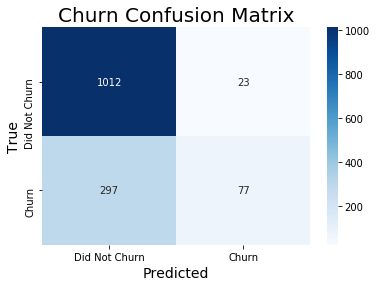

              precision    recall  f1-score   support

           0       0.77      0.98      0.86      1035
           1       0.77      0.21      0.32       374

    accuracy                           0.77      1409
   macro avg       0.77      0.59      0.59      1409
weighted avg       0.77      0.77      0.72      1409

Confusion Matrix for Non-Selected Feature Dataset


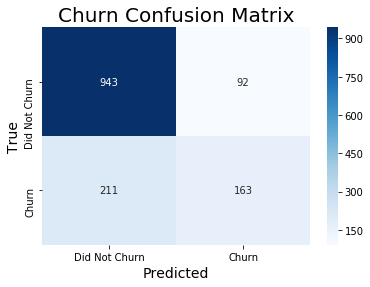

              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1035
           1       0.64      0.44      0.52       374

    accuracy                           0.78      1409
   macro avg       0.73      0.67      0.69      1409
weighted avg       0.77      0.78      0.77      1409



In [30]:
# Train on all training data and predict on hold-out set

# Fit baseline model to all selected feature training data
neurons = [100, 100, 100]
model = create_baseline_model(n_units=n_cols, n_cols=n_cols)
_ = add_model_layers(model, neurons)
_ = finish_model(model)
model.fit(X_train, y_train, epochs=10, batch_size=5, verbose=False)

# Fit baseline model to all non-selected feature training data
neurons = [100, 100, 100]
model_all = create_baseline_model(n_units=n_cols_all, n_cols=n_cols_all)
_ = add_model_layers(model_all, neurons)
_ = finish_model(model_all)
model_all.fit(X_train_all, y_train_all, epochs=10, batch_size=5, verbose=False)

# Make predictions on testing data and print classification report
y_pred_100n_clean = activate_output(model.predict(X_test))
print('Confusion Matrix for Selected Feature Dataset')
_ = plot_results(y_test, y_pred_100n_clean)
cr_100n_clean = plot_results(y_test, y_pred_100n_clean, output_dict=True)

y_pred_100n_all = activate_output(model_all.predict(X_test_all))
print('Confusion Matrix for Non-Selected Feature Dataset')
_ = plot_results(y_test_all, y_pred_100n_all)
cr_100n_all = plot_results(y_test_all, y_pred_100n_all, output_dict=True)

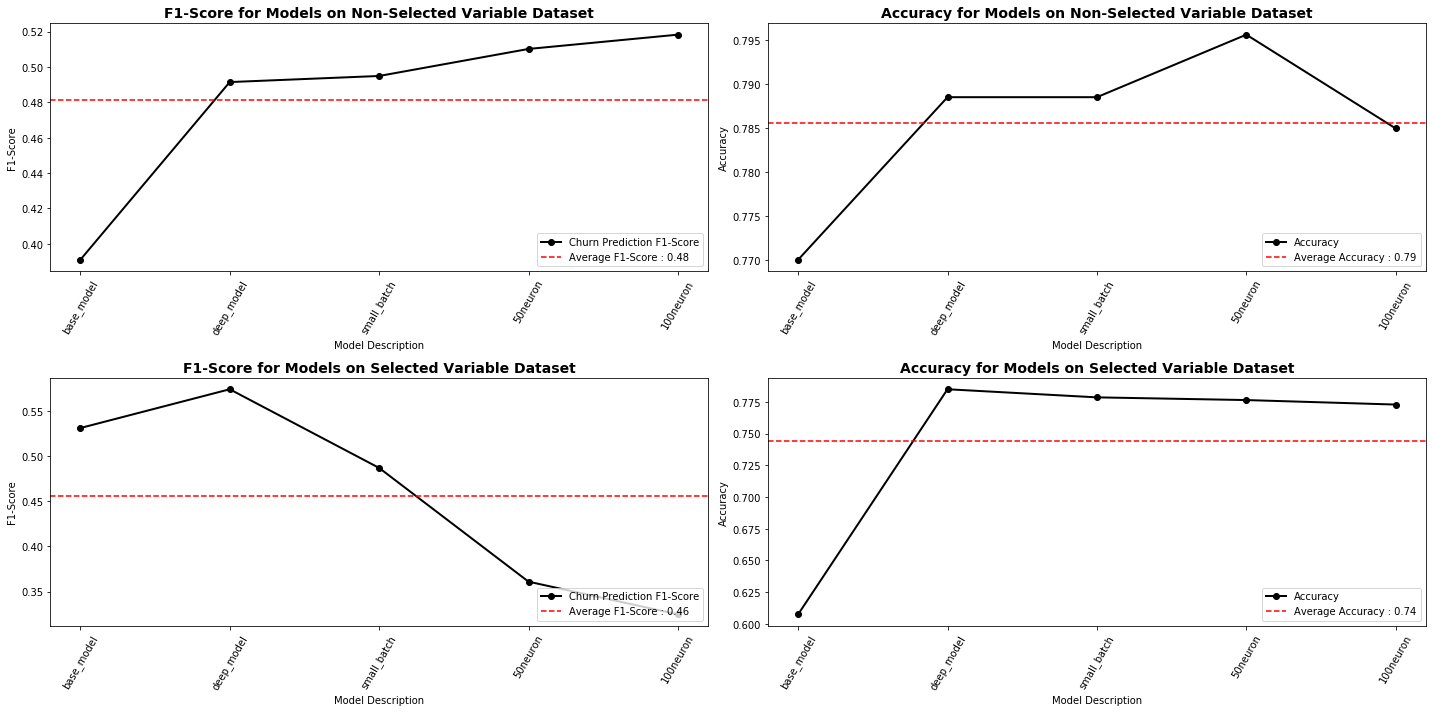

In [31]:
# Plot 100 neuron / layer performance
f1_dict_all['100neuron'] = cr_100n_all['1']['f1-score']
acc_dict_all['100neuron'] = cr_100n_all['accuracy']
f1_dict_clean['100neuron'] = cr_100n_clean['1']['f1-score']
acc_dict_clean['100neuron'] = cr_100n_clean['accuracy']
_ = plot_f1_acc(f1_dict_all, acc_dict_all, f1_dict_clean, acc_dict_clean)

---

## Adding More Hidden Layers

### 5 Hidden Layers, 50 Neurons/Layer

In [32]:
# Performs 5-Fold CV on the selected feature data using a 5 hidden layer model w 50 neurons/layer
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores= []

# Add a layer with n_cols number of neurons
neurons = [50, 50, 50, 50, 50]
for train, test in kfold.split(X_train, y_train):
    # Model architecture
    model = create_baseline_model(n_units=n_cols, n_cols=n_cols)
    _ = add_model_layers(model, neurons)
    _ = finish_model(model)
    
    # Model Evaluation
    model.fit(X_train[train], y_train[train], epochs=10, batch_size=5, verbose=False)
    scores = model.evaluate(X_train[test], y_train[test], verbose=False)
    print(f"Accuracy on Selected Feature Dataset: {scores[1]*100:.2f}%")
    cv_scores.append(scores[1] * 100)
    
# Average model performance
print(f"{np.mean(cv_scores):.2f}% (+/- {np.std(cv_scores):.2f}%)")

Accuracy on Selected Feature Dataset: 77.11%
Accuracy on Selected Feature Dataset: 77.99%
Accuracy on Selected Feature Dataset: 77.20%
Accuracy on Selected Feature Dataset: 78.35%
Accuracy on Selected Feature Dataset: 75.93%
77.32% (+/- 0.84%)


In [33]:
# Performs 5-Fold CV on the selected feature data using a 5 hidden layer model w 50 neurons/layer
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores=[]

neurons = [50, 50, 50, 50, 50]
for train, test in kfold.split(X_train_all, y_train_all):
    # Model Architecture
    model = create_baseline_model(n_units=n_cols_all, n_cols=n_cols_all)
    _ = add_model_layers(model, neurons)
    _ = finish_model(model)
    
    model.fit(X_train_all[train], y_train_all[train], epochs=10, batch_size=5, verbose=False)
    scores = model.evaluate(X_train_all[test], y_train_all[test], verbose=False)
    print(f"Accuracy on Non-Selected Feature Dataset {scores[1]*100:.2f}%")
    cv_scores.append(scores[1] * 100)
print(f"{np.mean(cv_scores):.2f}% (+/- {np.std(cv_scores):.2f}%)")

Accuracy on Non-Selected Feature Dataset 78.88%
Accuracy on Non-Selected Feature Dataset 79.24%
Accuracy on Non-Selected Feature Dataset 79.15%
Accuracy on Non-Selected Feature Dataset 78.44%
Accuracy on Non-Selected Feature Dataset 79.75%
79.09% (+/- 0.43%)


Confusion Matrix for Selected Feature Dataset


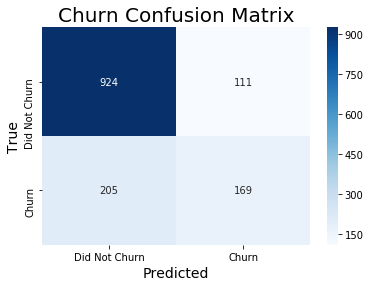

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1035
           1       0.60      0.45      0.52       374

    accuracy                           0.78      1409
   macro avg       0.71      0.67      0.69      1409
weighted avg       0.76      0.78      0.76      1409

Confusion Matrix for Non-Selected Feature Dataset


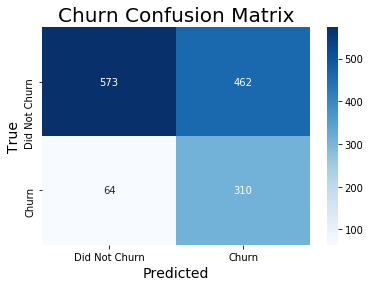

              precision    recall  f1-score   support

           0       0.90      0.55      0.69      1035
           1       0.40      0.83      0.54       374

    accuracy                           0.63      1409
   macro avg       0.65      0.69      0.61      1409
weighted avg       0.77      0.63      0.65      1409



In [34]:
# Train on all training data and predict on hold-out set

# Fit baseline model to all selected feature training data
neurons = [50, 50, 50, 50, 50]
model = create_baseline_model(n_units=n_cols, n_cols=n_cols)
_ = add_model_layers(model, neurons)
_ = finish_model(model)
model.fit(X_train, y_train, epochs=10, batch_size=5, verbose=False)

# Fit baseline model to all non-selected feature training data
neurons = [50, 50, 50, 50, 50]
model_all = create_baseline_model(n_units=n_cols_all, n_cols=n_cols_all)
_ = add_model_layers(model_all, neurons)
_ = finish_model(model_all)
model_all.fit(X_train_all, y_train_all, epochs=10, batch_size=5, verbose=False)

# Make predictions on testing data and print classification report
y_pred_50n_5l_clean = activate_output(model.predict(X_test))
print('Confusion Matrix for Selected Feature Dataset')
_ = plot_results(y_test, y_pred_50n_5l_clean)
cr_50n_5l_clean = plot_results(y_test, y_pred_50n_5l_clean, output_dict=True)

y_pred_50n_5l_all = activate_output(model_all.predict(X_test_all))
print('Confusion Matrix for Non-Selected Feature Dataset')
_ = plot_results(y_test_all, y_pred_50n_5l_all)
cr_50n_5l_all = plot_results(y_test_all, y_pred_50n_5l_all, output_dict=True)

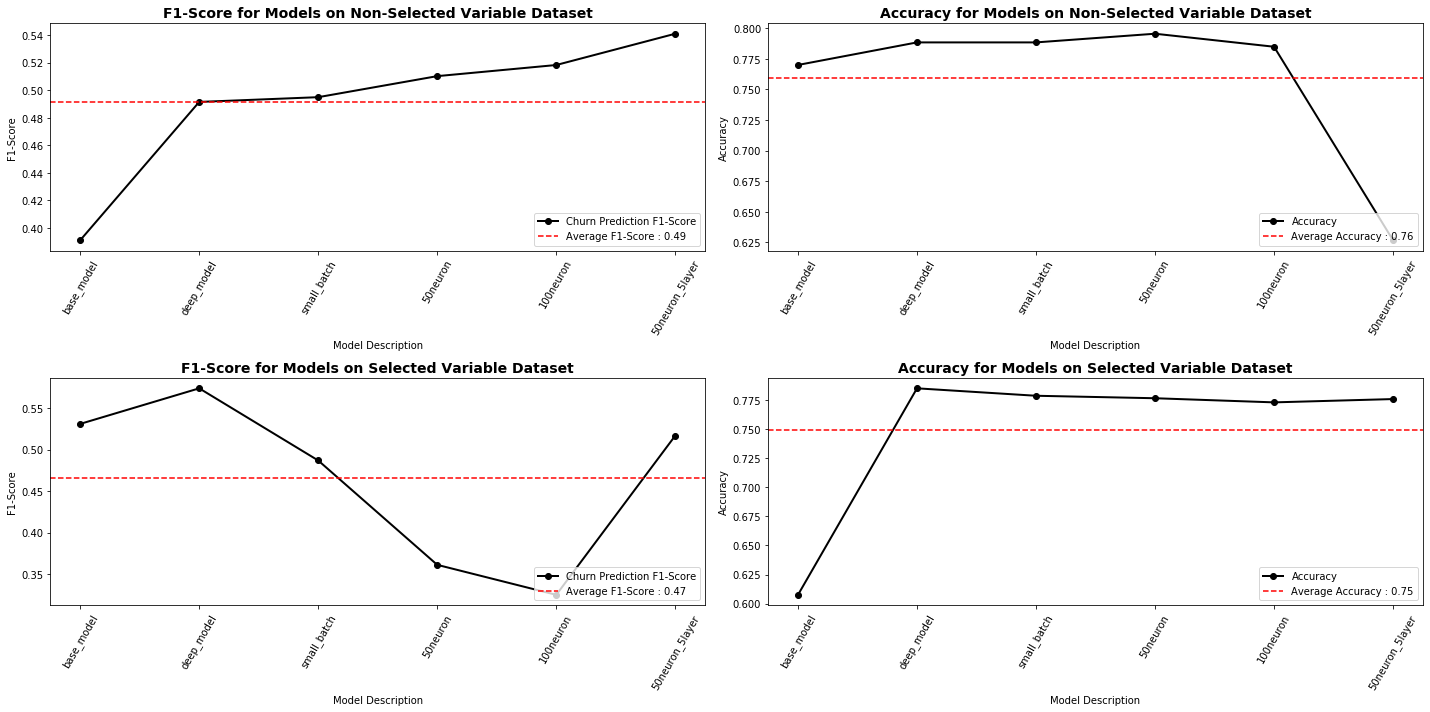

In [35]:
# Plot 5 layer 50 neuron performance results
f1_dict_all['50neuron_5layer'] = cr_50n_5l_all['1']['f1-score']
acc_dict_all['50neuron_5layer'] = cr_50n_5l_all['accuracy']
f1_dict_clean['50neuron_5layer'] = cr_50n_5l_clean['1']['f1-score']
acc_dict_clean['50neuron_5layer'] = cr_50n_5l_clean['accuracy']
_ = plot_f1_acc(f1_dict_all, acc_dict_all, f1_dict_clean, acc_dict_clean)

---

Problem doesn't have the complexity to warrant the use of a neural network
Not surprising that logistic regression performed best
    Must build baseline problems first
    Understand that logistic regression is okay
        LR assumes independence between all variables
    Structure of data isn't complex, the data columns are independent of one another
    How much better is logistic regression?
        If LR is nominally better than other models, best to use more complex models
        More complex models work better on more data
    Context of where the project is going to be deployed is necessary
        What business problem will the project be used on
        
Need to understand O time notation
    Understand how to save time in code
    Factorization code - doing code outside of loops / iterating through entire dataframe
    Data Management
        SQL or Pandas, Data Structures/Algorithms/Big O Notation